In [1]:
import os
import joblib
import numpy as np
import pandas as pd
import re

# ================================================================
# Paths
# ================================================================
results_base = "/n/groups/patel/adithya/UKB_Ratios/ukb_ratios/results/protein_ratios_alone/individual_results"
outcome_meta_path = "/n/groups/patel/randy/rfb/tidy_data/UKBiobank/all_outcomes"
fieldmap_path = "/home/adm808/ukb_ratios_folder/field.txt"
folds = range(5)
model_filename = "flaml_best_model.joblib"

# ================================================================
# Load outcome metadata
# ================================================================
outcomes_list = pd.read_csv(
    f"{outcome_meta_path}/outcome_colnames.txt",
    header=None
)[0].tolist()

fields = pd.read_csv(fieldmap_path, sep="\t", dtype=str)

# Helper: map index → disease name
def map_outcome_index_to_name(idx):
    raw_col = outcomes_list[idx]
    field_id = raw_col.split("-")[0]
    match = fields.loc[fields["field_id"] == field_id]

    if not match.empty:
        disease_name = match.iloc[0]["title"]
        disease_name = re.sub(r"^Date.*first reported\s*", "", disease_name).strip()
        return disease_name.lower()
    else:
        return None

# Helper: find outcome index containing a search string
def find_outcome_index(name_substring):
    target = name_substring.lower()
    for idx in range(len(outcomes_list)):
        disease = map_outcome_index_to_name(idx)
        if disease and target in disease:
            return idx
    return None

# ================================================================
# Find outcome indices for the 3 diseases
# ================================================================
parkinson_idx = find_outcome_index("parkinson's disease")
vascular_idx = find_outcome_index("vascular dementia")
stroke_idx = find_outcome_index("stroke, not specified as haemorrhage or infarction")

print("Outcome indices:")
print("Parkinson's:", parkinson_idx)
print("Vascular dementia:", vascular_idx)
print("Stroke:", stroke_idx)

# ================================================================
# Load feature importances for each fold
# ================================================================
def load_fold_importances(outcome_number):
    all_imps = []
    feature_names = None

    for fold in folds:
        model_path = os.path.join(
            results_base, f"outcome_{outcome_number}", f"fold_{fold}", model_filename
        )

        if not os.path.exists(model_path):
            print(f"Missing model for fold {fold}: {model_path}")
            continue

        model = joblib.load(model_path)

        try:
            booster = model.model.estimator  # FLAML wrapper
        except:
            booster = model  # fallback (rare)

        feature_names = booster.feature_name_
        importances = booster.feature_importances_.astype(float)
        all_imps.append(importances)

    return feature_names, all_imps

# ================================================================
# Normalize importances within fold + average
# ================================================================
def normalize_and_average(feature_names, fold_imps):
    normalized = []

    for imp in fold_imps:
        imp = np.array(imp)
        imp = imp / (imp.sum() + 1e-12)
        normalized.append(imp)

    normalized = np.vstack(normalized)
    mean_imp = normalized.mean(axis=0)
    std_imp = normalized.std(axis=0)

    df = pd.DataFrame({
        "feature": feature_names,
        "mean_importance": mean_imp,
        "std_importance": std_imp
    }).sort_values("mean_importance", ascending=False)

    return df

# ================================================================
# Compute feature importance summaries
# ================================================================
df_parkinson = None
df_vascular = None
df_stroke = None

disease_map = {
    "parkinson": parkinson_idx,
    "vascular": vascular_idx,
    "stroke": stroke_idx
}

for disease, outcome_idx in disease_map.items():
    if outcome_idx is None:
        print(f"Outcome not found for: {disease}")
        continue

    feature_names, fold_imps = load_fold_importances(outcome_idx)
    df = normalize_and_average(feature_names, fold_imps)

    if disease == "parkinson":
        df_parkinson = df
    elif disease == "vascular":
        df_vascular = df
    elif disease == "stroke":
        df_stroke = df

print("\n=== Parkinson's disease: top features ===")
display(df_parkinson.head(20))

print("\n=== Vascular dementia: top features ===")
display(df_vascular.head(20))

print("\n=== Stroke: top features ===")
display(df_stroke.head(20))

Outcome indices:
Parkinson's: 133
Vascular dementia: 98
Stroke: 261

=== Parkinson's disease: top features ===


,feature,mean_importance,std_importance
60,919-0__minus__2148-0,0.030361,0.010330
41,1455-0__minus__2148-0,0.029447,0.018079
77,2354-0__minus__1840-0,0.028988,0.002610
2,883-0__minus__1455-0,0.026880,0.007537
69,2148-0__minus__2354-0,0.025739,0.009443
98,1137-0__minus__232-0,0.022658,0.006774
6,883-0__minus__2354-0,0.022399,0.007793
50,2854-0__minus__919-0,0.022211,0.005536
76,2148-0__minus__232-0,0.021884,0.009338
90,1454-0__minus__1137-0,0.020801,0.006581



=== Vascular dementia: top features ===


,feature,mean_importance,std_importance
76,1288-0__minus__559-0,0.032487,0.008062
8,1141-0__minus__2854-0,0.032039,0.006661
6,1141-0__minus__242-0,0.031304,0.009688
14,1141-0__minus__883-0,0.022473,0.006284
7,1141-0__minus__154-0,0.021446,0.007383
50,131-0__minus__2854-0,0.021433,0.008313
28,1840-0__minus__1008-0,0.020642,0.008521
39,1137-0__minus__1369-0,0.019812,0.007472
122,1369-0__minus__711-0,0.019123,0.005658
93,242-0__minus__1827-0,0.017940,0.003374



=== Stroke: top features ===


,feature,mean_importance,std_importance
3,1137-0__minus__2065-0,0.035637,0.006574
14,902-0__minus__979-0,0.034375,0.013715
90,883-0__minus__242-0,0.034334,0.006593
103,121-0__minus__2184-0,0.032746,0.012399
64,768-0__minus__242-0,0.031450,0.007675
98,242-0__minus__2184-0,0.027494,0.012482
10,1137-0__minus__2270-0,0.024818,0.004919
2,1137-0__minus__2868-0,0.022248,0.010982
81,1578-0__minus__121-0,0.022027,0.002740
12,1137-0__minus__57-0,0.021906,0.011480


In [2]:
# ================================================================
# Load UKB proteomics coding → gene symbol map
# ================================================================
coding_map_df = pd.read_csv("/home/adm808/ukb_ratios_folder/coding143_ukb.tsv", sep="\t")

# coding column = numeric ID; meaning = "Gene;Description"
coding_map = {}

for _, row in coding_map_df.iterrows():
    code = str(row["coding"]).strip()  # '1455', etc.
    gene = str(row["meaning"]).split(";")[0].strip()
    coding_map[code] = gene


# ================================================================
# Convert raw feature name → readable ratio
# Example: "1455-0__minus__1454-0" → "A1BG / AAMDC"
# ================================================================
def decode_feature_name(raw_feature):
    """
    Convert UKB ratio feature names like:
    '1455-0__minus__1454-0'
    into readable gene ratios like:
    'A1BG / AAMDC'
    """
    # Split "1455-0" → "1455"
    def extract_id(piece):
        return piece.split("-")[0]

    if "__minus__" in raw_feature:
        left, right = raw_feature.split("__minus__")

        id_left = extract_id(left)
        id_right = extract_id(right)

        gene_left = coding_map.get(id_left, f"ID_{id_left}")
        gene_right = coding_map.get(id_right, f"ID_{id_right}")

        return f"{gene_left} / {gene_right}"

    # fallback if not a ratio
    id_only = extract_id(raw_feature)
    return coding_map.get(id_only, f"ID_{id_only}")


# ================================================================
# Apply decoding to all 3 DataFrames
# ================================================================
def apply_decoding(df):
    df = df.copy()
    df["readable_feature"] = df["feature"].apply(decode_feature_name)
    return df

df_parkinson_readable = apply_decoding(df_parkinson)
df_vascular_readable = apply_decoding(df_vascular)
df_stroke_readable = apply_decoding(df_stroke)

print("Decoded top Parkinson’s features:")
display(df_parkinson_readable.head(20))

print("Decoded top Vascular dementia features:")
display(df_vascular_readable.head(20))

print("Decoded top Stroke features:")
display(df_stroke_readable.head(20))

Decoded top Parkinson’s features:


,feature,mean_importance,std_importance,readable_feature
60,919-0__minus__2148-0,0.030361,0.010330,ELN / PRL
41,1455-0__minus__2148-0,0.029447,0.018079,ITGAV / PRL
77,2354-0__minus__1840-0,0.028988,0.002610,SCG2 / NEFL
2,883-0__minus__1455-0,0.026880,0.007537,EDA2R / ITGAV
69,2148-0__minus__2354-0,0.025739,0.009443,PRL / SCG2
98,1137-0__minus__232-0,0.022658,0.006774,GDF15 / BAG3
6,883-0__minus__2354-0,0.022399,0.007793,EDA2R / SCG2
50,2854-0__minus__919-0,0.022211,0.005536,VGF / ELN
76,2148-0__minus__232-0,0.021884,0.009338,PRL / BAG3
90,1454-0__minus__1137-0,0.020801,0.006581,ITGAM / GDF15


Decoded top Vascular dementia features:


,feature,mean_importance,std_importance,readable_feature
76,1288-0__minus__559-0,0.032487,0.008062,HPGDS / CHI3L1
8,1141-0__minus__2854-0,0.032039,0.006661,GFAP / VGF
6,1141-0__minus__242-0,0.031304,0.009688,GFAP / BCAN
14,1141-0__minus__883-0,0.022473,0.006284,GFAP / EDA2R
7,1141-0__minus__154-0,0.021446,0.007383,GFAP / APOE
50,131-0__minus__2854-0,0.021433,0.008313,ANXA10 / VGF
28,1840-0__minus__1008-0,0.020642,0.008521,NEFL / FASLG
39,1137-0__minus__1369-0,0.019812,0.007472,GDF15 / IL13RA1
122,1369-0__minus__711-0,0.019123,0.005658,IL13RA1 / CST5
93,242-0__minus__1827-0,0.017940,0.003374,BCAN / NCS1


Decoded top Stroke features:


,feature,mean_importance,std_importance,readable_feature
3,1137-0__minus__2065-0,0.035637,0.006574,GDF15 / PLA2G7
14,902-0__minus__979-0,0.034375,0.013715,EGFR / F10
90,883-0__minus__242-0,0.034334,0.006593,EDA2R / BCAN
103,121-0__minus__2184-0,0.032746,0.012399,ANGPTL3 / PTGDS
64,768-0__minus__242-0,0.031450,0.007675,DCBLD2 / BCAN
98,242-0__minus__2184-0,0.027494,0.012482,BCAN / PTGDS
10,1137-0__minus__2270-0,0.024818,0.004919,GDF15 / REN
2,1137-0__minus__2868-0,0.022248,0.010982,GDF15 / VSIG4
81,1578-0__minus__121-0,0.022027,0.002740,LGALS4 / ANGPTL3
12,1137-0__minus__57-0,0.021906,0.011480,GDF15 / ADGRG2


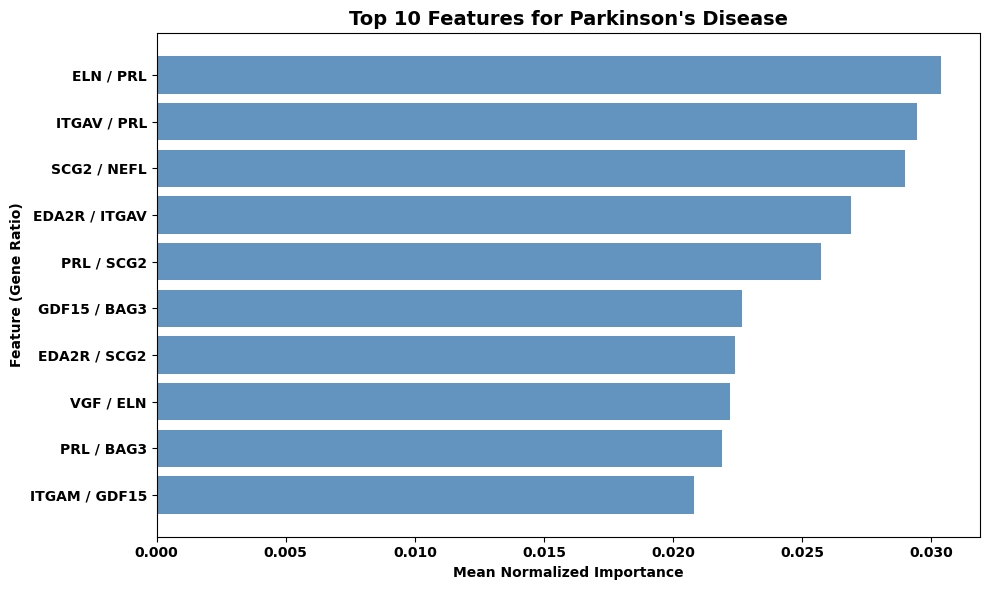

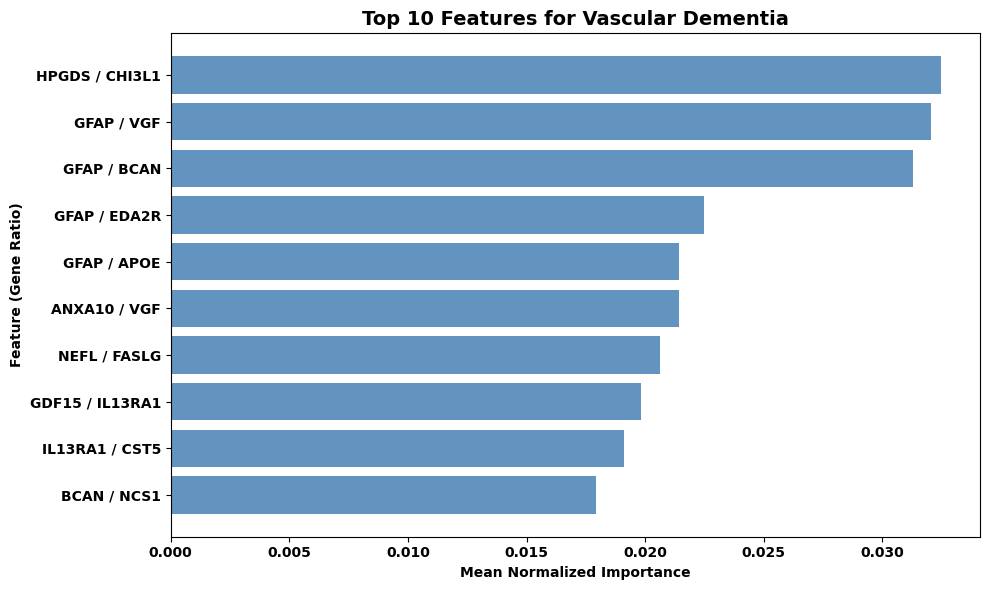

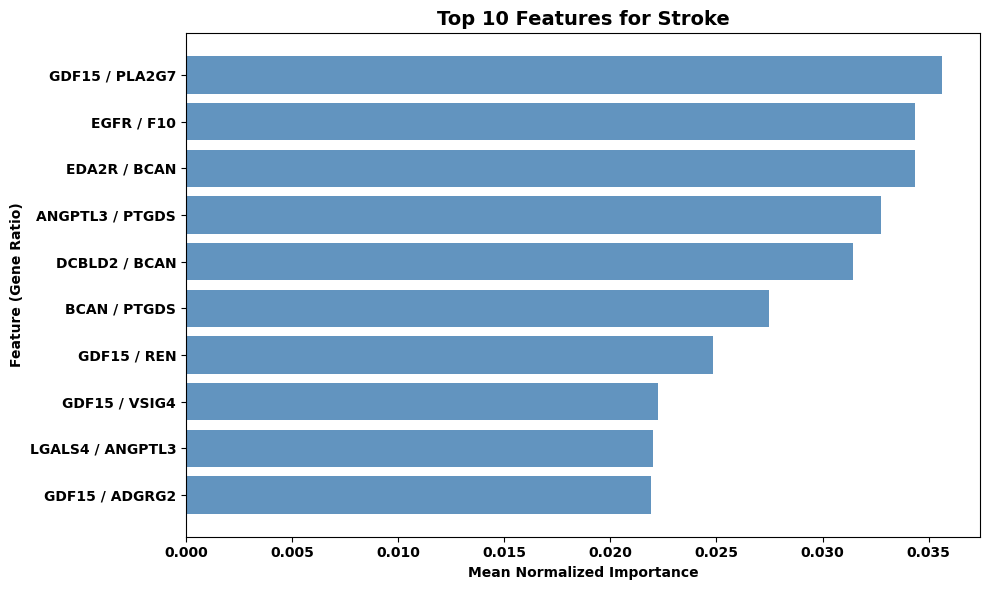

In [3]:
import matplotlib.pyplot as plt

def plot_top_features(df, disease_name, top_n=10):
    # Take top N
    top_df = df.head(top_n).iloc[::-1]  # reverse for top-down plotting

    plt.figure(figsize=(10, 6))
    plt.barh(
        top_df["readable_feature"],
        top_df["mean_importance"],
        color="steelblue",
        alpha=0.85
    )

    # === Bold labels ===
    plt.xlabel("Mean Normalized Importance", fontweight="bold")
    plt.ylabel("Feature (Gene Ratio)", fontweight="bold")
    plt.title(f"Top {top_n} Features for {disease_name}", fontweight="bold", fontsize=14)

    # === Bold y-axis tick labels (feature names) ===
    plt.yticks(fontweight="bold")
    plt.xticks(fontweight="bold")

    plt.tight_layout()
    plt.show()


# ================================================================
# Generate plots
# ================================================================
plot_top_features(df_parkinson_readable, "Parkinson's Disease")
plot_top_features(df_vascular_readable, "Vascular Dementia")
plot_top_features(df_stroke_readable, "Stroke")